<a href="https://colab.research.google.com/github/Edenshmuel/ICU_Nutrition_ML/blob/main/Neural_Network_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the Data**

Importing Necessary Libraries

In [1]:
import copy
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Cloning the Project Repository

In [41]:
!git clone https://github.com/Edenshmuel/ICU_Nutrition_ML.git

Cloning into 'ICU_Nutrition_ML'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 453.19 KiB | 10.07 MiB/s, done.
Resolving deltas: 100% (6/6), done.


Loading the Dataset

In [42]:
df = pd.read_csv("https://raw.githubusercontent.com/Edenshmuel/ICU_Nutrition_ML/refs/heads/main/Food_and_Nutrition__.csv")
df.head()

,Ages,Gender,Height,Weight,Activity Level,Dietary Preference,Daily Calorie Target,Protein,Sugar,Sodium,Calories,Carbohydrates,Fiber,Fat,Breakfast Suggestion,Lunch Suggestion,Dinner Suggestion,Snack Suggestion,Disease
0,25,Male,180,80,Moderately Active,Omnivore,2000,120,125.0,24.0,2020,250,30.0,60,Oatmeal with berries and nuts,Grilled chicken salad with mixed greens,Salmon with roasted vegetables,Greek yogurt with fruit,Weight Gain
1,32,Female,165,65,Lightly Active,Vegetarian,1600,80,100.0,16.0,1480,200,24.0,40,Tofu scramble with veggies,Lentil soup with whole wheat bread,Vegetable stir-fry with brown rice,Apple with almond butter,"Weight Gain, Hypertension, Heart Disease"
2,48,Male,175,95,Sedentary,Vegan,2200,100,150.0,20.0,2185,300,36.0,65,Tofu and veggie breakfast burrito,Black bean burger on a whole wheat bun,Lentil and vegetable curry,Trail mix,Weight Gain
3,55,Female,160,70,Very Active,Omnivore,2500,140,175.0,28.0,2680,350,42.0,80,Greek yogurt with granola and fruit,Chicken and vegetable stir-fry,Turkey chili with brown rice,Banana with peanut butter,Weight Gain
4,62,Male,170,85,Sedentary,Vegetarian,2000,80,125.0,16.0,1815,250,30.0,55,Scrambled eggs with whole wheat toast and avocado,Quinoa salad with chickpeas and vegetables,Vegetarian chili with cornbread,Fruit and nut mix,Weight Gain


**Data Preprocessing**

Categorize Features: Numerical, Categorical, and Skewed Columns

In [45]:
numerical_features = ["Ages", "Height", "Weight", "Fiber", "Sodium"]
categorical_features = ["Gender", "Dietary Preference"]

Features identified as right-skewed from EDA. Applying log transformation

In [10]:
right_skewed_features = ["Fat"]

**Data Preprocessing: Pipelines for Scaling, Encoding, and Log Transformation**

Log Transform + Scaling for skewed features

In [11]:
log_scaler_pipeline = Pipeline(steps=[("log_transform", FunctionTransformer(np.log1p, validate=True)),
    ("scaler", StandardScaler())])

Standard Scaling for non-skewed features

In [12]:
scaler_pipeline = Pipeline(steps=[("scaler", StandardScaler())])

One-Hot Encoding for categorical features

In [13]:
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

This function converts the "Disease" column, which contains multiple diseases as a comma-separated string, into a multi-hot encoded format—creating a separate binary column for each unique disease

In [14]:
def multi_hot_encode_disease(df):
    df = df.copy()
    df["Disease"] = df["Disease"].astype(str).str.split(", ")
    all_diseases = set([d for sublist in df["Disease"] for d in sublist])

    for disease in all_diseases:
        df[disease] = df["Disease"].apply(lambda x: 1 if disease in x else 0)

    df = df.drop(columns=["Disease"])
    return df

disease_transformer = FunctionTransformer(multi_hot_encode_disease)

This code transforms the categorical "Activity Level" column into numerical values, making it suitable for machine learning models

In [9]:
df["Activity Level"].unique()

array(['Moderately Active', 'Lightly Active', 'Sedentary', 'Very Active',
       'Extremely Active'], dtype=object)

In [15]:
activity_mapping = {
    "Sedentary": 0,
    "Lightly Active": 1,
    "Moderately Active": 2,
    "Very Active": 3,
    "Extremely Active": 4
    }

In [16]:
def encode_activity_level(X):
    X = X.copy()
    X["Activity Level"] = X["Activity Level"].map(activity_mapping)
    return X

activity_transformer = FunctionTransformer(encode_activity_level)

This class is a custom scikit-learn transformer that calculates the Body Mass Index (BMI) based on weight and height

In [17]:
class BMICalculator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["BMI"] = X["Weight"] / (X["Height"] ** 2)
        return X

Defines the preprocessing pipeline

In [18]:
num_pipeline = Pipeline(steps=[
    ("bmi_calculator", BMICalculator()),
    ("log_scaled", log_scaler_pipeline),
    ("scaler", scaler_pipeline)])

In [19]:
preprocessor = ColumnTransformer(transformers=[
    ("log_scaled", log_scaler_pipeline, right_skewed_features),
    ("scaled", scaler_pipeline, numerical_features),
    ("activity", activity_transformer, ["Activity Level"]),
    ("cat", cat_transformer, categorical_features),
    ("disease", disease_transformer, ["Disease"])])

To ensure consistency, we remove diseases that appear only once, as they cause mismatched features between training and test sets and provide no learning value for the model

In [40]:
from collections import Counter

df["Disease_Split"] = df["Disease"].astype(str).str.split(", ")

all_diseases = [disease for sublist in df["Disease_Split"] for disease in sublist]
disease_counts = Counter(all_diseases)

print("Single disease count:")
for disease, count in disease_counts.items():
    print(f"{disease}: {count}")

rare_diseases = [disease for disease, count in disease_counts.items() if count < 2]

print("\nRare diseases (appear less than 2 times):")
print(rare_diseases)

Single disease count:
Weight Gain: 1664
Hypertension: 291
Heart Disease: 288
Kidney Disease: 188
Diabetes: 65
Acne: 65

Rare diseases (appear less than 2 times):
[]


In [21]:
df = df[~df["Disease"].str.contains("Weight Loss", na=False)]

In [22]:
X = df.drop(columns=["Daily Calorie Target", "Protein", "Carbohydrates"])
y = df[["Daily Calorie Target", "Protein", "Carbohydrates"]]

Prevent Data Leakage: Remove Columns That Contain Target Information

In [46]:
X = df.drop(columns=["Calories"])

Removing Non-Contributing Columns

In [47]:
columns_to_remove = ["Sugar", "Breakfast Suggestion", "Lunch Suggestion",
                     "Dinner Suggestion", "Snack Suggestion"]

X = df.drop(columns=columns_to_remove)

Analysis showed that keeping 'Sodium' and 'Fiber' significantly reduced the model's error, so I decided to keep them

**Splitting the Data**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Y Train: {y_train.shape}, Y Test: {y_test.shape}")

Train: (1357, 17), Test: (340, 17)
Y Train: (1357, 3), Y Test: (340, 3)


**Apply the Pipeline**

In [26]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [27]:
print(f"✅ Training Data Processed: {X_train_transformed.shape} (Rows, Features)")
print(f"✅ Test Data Processed: {X_test_transformed.shape} (Rows, Features)")

✅ Training Data Processed: (1357, 19) (Rows, Features)
✅ Test Data Processed: (340, 19) (Rows, Features)


**Baseline Model**

A baseline model is created by randomly shuffling the target values to compare the neural network's performance against a naive prediction

In [29]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [30]:
y_test_copy = np.array(copy.deepcopy(y_test))

np.random.shuffle(y_test_copy)

random_baseline_mae = mean_absolute_error(y_test, y_test_copy, multioutput="raw_values")
random_baseline_mse = mean_squared_error(y_test, y_test_copy, multioutput="raw_values")
random_baseline_rmse = np.sqrt(random_baseline_mse)
random_baseline_r2 = r2_score(y_test, y_test_copy, multioutput="raw_values")

print(f"Random Baseline MAE per target: {random_baseline_mae}")
print(f"Average Random Baseline MAE: {random_baseline_mae.mean():.2f}")

print(f"Random Baseline MSE per target: {random_baseline_mse}")
print(f"Average Random Baseline MSE: {random_baseline_mse.mean():.2f}")

print(f"Random Baseline RMSE per target: {random_baseline_rmse}")
print(f"Average Random Baseline RMSE: {random_baseline_rmse.mean():.2f}")

print(f"Random Baseline R² per target: {random_baseline_r2}")
print(f"Average Random Baseline R²: {random_baseline_r2.mean():.2f}")

Random Baseline MAE per target: [652.07058824  58.22941176  83.84117647]
Average Random Baseline MAE: 264.71
Random Baseline MSE per target: [639625.06470588   5605.51764706  10604.51176471]
Average Random Baseline MSE: 218611.70
Random Baseline RMSE per target: [799.76563111  74.87000499 102.97821015]
Average Random Baseline RMSE: 325.87
Random Baseline R² per target: [-0.95746214 -0.88139212 -1.13146271]
Average Random Baseline R²: -0.99


**Neural Network Model**

This section defines and trains a neural network using K-Fold cross-validation. The model includes batch normalization, dropout, L2 regularization, and an exponentially decaying learning rate. The Mean Absolute Error (MAE) is calculated for each fold and averaged across all folds



In [205]:
#!pip install scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 57.7 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [32]:
#!pip install --upgrade scikit-learn scikeras --quiet

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [34]:
y_train_np = y_train.to_numpy()

In [35]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.96, staircase=True)

In [36]:
def build_model():
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_transformed.shape[1],)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(y_train.shape[1], activation='linear')])

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [37]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

mae_per_column = []

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for train_idx, val_idx in kfold.split(X_train_transformed):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

    model = build_model()

    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=16, verbose=1,
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

    y_val_pred = model.predict(X_val_fold)

    fold_mae_per_column = mean_absolute_error(y_val_fold, y_val_pred, multioutput="raw_values")

    mae_per_column.append(fold_mae_per_column)

    print(f"MAE per column in the current fold: {fold_mae_per_column}")

mae_per_column = np.array(mae_per_column)

mean_mae_per_column = mae_per_column.mean(axis=0)

print("\nAverage MAE per column:")
for i, col_name in enumerate(["Calories", "Carbohydrates", "Protein"]):
    print(f"{col_name}: {mean_mae_per_column[i]:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 1841707.1250 - mae: 883.8734 - val_loss: 1825997.3750 - val_mae: 876.9918
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1827289.6250 - mae: 867.6946 - val_loss: 1701101.1250 - val_mae: 831.2814
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1653976.1250 - mae: 797.0502 - val_loss: 1455802.0000 - val_mae: 775.8879
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1359196.0000 - mae: 715.9122 - val_loss: 1250301.0000 - val_mae: 713.7136
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1097184.8750 - mae: 639.2917 - val_loss: 928126.5625 - val_mae: 601.0317
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 823243.6875 - mae: 549.0182 - val_loss: 626268.8750 - val_mae: 485.1999
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 576688.1250 - mae: 454.7196 - val_loss: 402042.5000 - val_mae: 378.3793
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 361672.9062 - mae: 3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1838993.7500 - mae: 882.7801 - val_loss: 1820701.2500 - val_mae: 887.6991
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1774983.0000 - mae: 854.3634 - val_loss: 1711187.6250 - val_mae: 843.0475
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1631232.0000 - mae: 790.8019 - val_loss: 1561457.6250 - val_mae: 815.1654
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1412371.5000 - mae: 726.7025 - val_loss: 1243044.1250 - val_mae: 717.9425
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1085412.3750 - mae: 634.7966 - val_loss: 915272.9375 - val_mae: 594.9130
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 836923.3125 - mae: 552.7267 - val_loss: 645589.0625 - val_mae: 492.7608
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 564512.3125 - mae: 449.0529 - val_loss: 350020.0625 - val_mae: 352.2484
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 362333.1250 - mae: 355.1480 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1798240.1250 - mae: 875.2214 - val_loss: 1794855.8750 - val_mae: 856.9306
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1809667.0000 - mae: 861.8860 - val_loss: 1709706.7500 - val_mae: 835.6140
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1564464.0000 - mae: 774.6193 - val_loss: 1394546.0000 - val_mae: 773.8145
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1376787.5000 - mae: 718.1082 - val_loss: 1116272.0000 - val_mae: 671.0596
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1096472.1250 - mae: 636.8955 - val_loss: 829078.2500 - val_mae: 568.3118
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 812523.5625 - mae: 544.6199 - val_loss: 574865.0000 - val_mae: 466.4154
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 582738.8750 - mae: 456.0569 - val_loss: 400668.0938 - val_mae: 380.8177
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 357033.3125 - mae: 352.3475 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1851907.6250 - mae: 888.5818 - val_loss: 1750999.6250 - val_mae: 854.7845
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1758214.7500 - mae: 851.0875 - val_loss: 1618127.1250 - val_mae: 811.0562
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1620905.3750 - mae: 788.6188 - val_loss: 1402364.8750 - val_mae: 760.5698
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1421636.6250 - mae: 727.6866 - val_loss: 1115757.2500 - val_mae: 675.8626
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1059718.7500 - mae: 626.7253 - val_loss: 806640.6875 - val_mae: 564.8498
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 858288.1875 - mae: 559.6974 - val_loss: 572713.4375 - val_mae: 463.2813
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 555102.6875 - mae: 446.0974 - val_loss: 361251.9688 - val_mae: 360.8895
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 371438.1250 - mae: 357.2711 - val_

**Plot Training vs. Validation Loss**

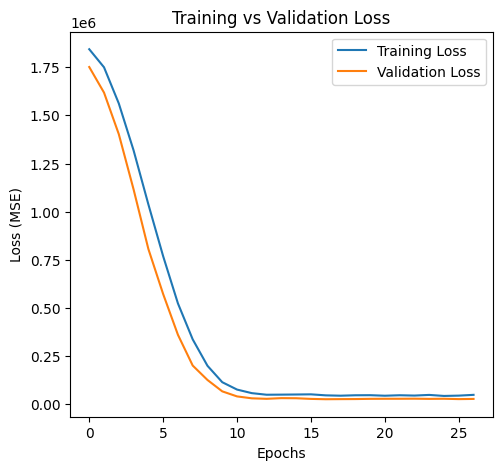

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss גרף
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()

**Model Evaluation**

In [39]:
y_test_pred = model.predict(X_test_transformed)

test_mae = mean_absolute_error(y_test, y_test_pred, multioutput="raw_values")
test_mse = mean_squared_error(y_test, y_test_pred, multioutput="raw_values")
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred, multioutput="raw_values")

print("\n🔹 **Model Performance Comparison vs. Baseline** 🔹")

print("\n📊 **MAE** (Mean Absolute Error):")
print(f"Random Baseline: {np.round([631.62, 58.01, 82.83], 2)}")
print(f"Model Performance: {np.round(test_mae, 2)}")

print("\n📊 **MSE** (Mean Squared Error):")
print(f"Random Baseline: {np.round([637653.03, 5360.05, 10613.26], 2)}")
print(f"Model Performance: {np.round(test_mse, 2)}")

print("\n📊 **RMSE** (Root Mean Squared Error):")
print(f"Random Baseline: {np.round([798.53, 73.21, 103.02], 2)}")
print(f"Model Performance: {np.round(test_rmse, 2)}")

print("\n📊 **R²** (Proportion of Variance Explained by the Model):")
print(f"Random Baseline: {np.round([-0.94, -0.94, -1.03], 2)}")
print(f"Model Performance: {np.round(test_r2, 2)}")

print("\n📊 **Average Metric Comparison Between Model and Baseline:**")
print(f"Average Random Baseline MAE: {np.round(257.49, 2)}, Model MAE: {np.round(test_mae.mean(), 2)}")
print(f"Average Random Baseline MSE: {np.round(217875.45, 2)}, Model MSE: {np.round(test_mse.mean(), 2)}")
print(f"Average Random Baseline RMSE: {np.round(324.92, 2)}, Model RMSE: {np.round(test_rmse.mean(), 2)}")
print(f"Average Random Baseline R²: {np.round(-0.97, 2)}, Model R²: {np.round(test_r2.mean(), 2)}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

🔹 **השוואת ביצועי המודל מול הבייסליין** 🔹

📊 **MAE** (שגיאה מוחלטת ממוצעת):
Random Baseline: [631.62  58.01  82.83]
Model Performance: [194.77  25.91  29.72]

📊 **MSE** (שגיאת ריבוע ממוצעת):
Random Baseline: [637653.03   5360.05  10613.26]
Model Performance: [84161.19   923.86  2026.24]

📊 **RMSE** (שורש שגיאת ריבוע ממוצעת):
Random Baseline: [798.53  73.21 103.02]
Model Performance: [290.11  30.39  45.01]

📊 **R²** (אחוז השונות שהמודל מסביר):
Random Baseline: [-0.94 -0.94 -1.03]
Model Performance: [0.74 0.69 0.59]

📊 **השוואת ממוצע המדדים בין המודל לבייסליין:**
Average Random Baseline MAE: 257.49, Model MAE: 83.47000122070312
Average Random Baseline MSE: 217875.45, Model MSE: 29037.08984375
Average Random Baseline RMSE: 324.92, Model RMSE: 121.83999633789062
Average Random Baseline R²: -0.97, Model R²: 0.6800000071525574
